In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [36]:
plt.style.use('seaborn')

In [2]:
houses_df = pd.read_csv('datasets/kc-house-data.csv')

In [3]:
houses_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
houses_df.shape

(21613, 21)

In [5]:
X_raw = houses_df.iloc[:, 3:]

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_raw, houses_df.iloc[:, 2], 
                                                    test_size=.35, random_state=43)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((14048, 18), (14048,), (7565, 18), (7565,))

In [7]:
X_train.isnull().sum()

bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [8]:
numerical = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement',
            'sqft_living15', 'sqft_lot15', 'yr_renovated', 'yr_built', 'lat', 'long']

binary = ['waterfront', 'zipcode']
quality = ['condition', 'grade']

In [9]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler

In [10]:
binary_ohe = OneHotEncoder()
quality_1 = LabelEncoder()
quality_2 = LabelEncoder()

numerical_scaler = MinMaxScaler()
quality_scaler = MinMaxScaler()
hot_scaler = StandardScaler()
y_scaler = MinMaxScaler()

scaled_numerical = numerical_scaler.fit_transform(X_train[numerical])
hot_encoded = binary_ohe.fit_transform(X_train[binary])
condition = quality_1.fit_transform(X_train['condition'].values.reshape(-1, 1))
grade = quality_2.fit_transform(X_train['grade'].values.reshape(-1, 1))

/home/dsntos/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [11]:
X_train_final = pd.DataFrame(scaled_numerical, columns=numerical)

condition = pd.DataFrame(condition.reshape(-1, 1))
grade = pd.DataFrame(grade.reshape(-1, 1))

cdt_grd = pd.concat([condition, grade], axis=1)
cdt_grd.columns = ['condition', 'grade']
cdt_grd = quality_scaler.fit_transform(cdt_grd)
cdt_grd = pd.DataFrame(cdt_grd, columns=['condition', 'grade'])

In [12]:
X_train_final = pd.concat([X_train_final, cdt_grd], axis=1)

In [13]:
scaled_hot = hot_scaler.fit_transform(pd.DataFrame(hot_encoded.toarray()))
scaled_hot = pd.DataFrame(scaled_hot)
X_train_final = pd.concat([X_train_final, scaled_hot], axis=1)

In [14]:
y_train_encoded = y_scaler.fit_transform(y_train.values.reshape(-1, 1))

In [15]:
#preparing model

In [58]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=250, activation='sigmoid', input_shape=(87,)))
model.add(tf.keras.layers.Dense(units=500, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=250, activation='relu'))
model.add(tf.keras.layers.Dense(units=500, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=100, activation='relu'))
model.add(tf.keras.layers.Dense(units=100, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='linear'))

In [59]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 250)               22000     
_________________________________________________________________
dense_15 (Dense)             (None, 500)               125500    
_________________________________________________________________
dropout_4 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 250)               125250    
_________________________________________________________________
dense_17 (Dense)             (None, 500)               125500    
_________________________________________________________________
dropout_5 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 100)              

In [60]:
#from tensorflow.keras.optimizers import Adam
model.compile(optimizer='Adam', loss='mean_squared_error')

In [61]:
epochs_hist = model.fit(X_train_final, y_train_encoded, epochs=150, batch_size=50, validation_split=0.2)

Epoch 1/150
225/225 [==============================] - 1s 6ms/step - loss: 0.0038 - val_loss: 0.0022
Epoch 2/150
225/225 [==============================] - 1s 6ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 3/150
225/225 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 4/150
225/225 [==============================] - 1s 6ms/step - loss: 0.0010 - val_loss: 8.9158e-04
Epoch 5/150
225/225 [==============================] - 1s 6ms/step - loss: 8.5011e-04 - val_loss: 7.8546e-04
Epoch 6/150
225/225 [==============================] - 1s 6ms/step - loss: 7.4218e-04 - val_loss: 6.1431e-04
Epoch 7/150
225/225 [==============================] - 1s 6ms/step - loss: 8.3050e-04 - val_loss: 0.0010
Epoch 8/150
225/225 [==============================] - 1s 6ms/step - loss: 7.0758e-04 - val_loss: 7.0204e-04
Epoch 9/150
225/225 [==============================] - 1s 6ms/step - loss: 6.9666e-04 - val_loss: 7.1913e-04
Epoch 10/150
225/225 [=============================

225/225 [==============================] - 1s 6ms/step - loss: 3.0892e-04 - val_loss: 0.0024
Epoch 79/150
225/225 [==============================] - 1s 6ms/step - loss: 3.3170e-04 - val_loss: 0.0022
Epoch 80/150
225/225 [==============================] - 1s 6ms/step - loss: 3.0148e-04 - val_loss: 0.0025
Epoch 81/150
225/225 [==============================] - 1s 6ms/step - loss: 2.9589e-04 - val_loss: 0.0019
Epoch 82/150
225/225 [==============================] - 1s 6ms/step - loss: 3.0646e-04 - val_loss: 0.0017
Epoch 83/150
225/225 [==============================] - 1s 6ms/step - loss: 3.1798e-04 - val_loss: 0.0016
Epoch 84/150
225/225 [==============================] - 1s 6ms/step - loss: 3.1283e-04 - val_loss: 0.0031
Epoch 85/150
225/225 [==============================] - 1s 6ms/step - loss: 3.3404e-04 - val_loss: 0.0018
Epoch 86/150
225/225 [==============================] - 1s 6ms/step - loss: 3.0455e-04 - val_loss: 0.0025
Epoch 87/150
225/225 [==============================] - 1s 

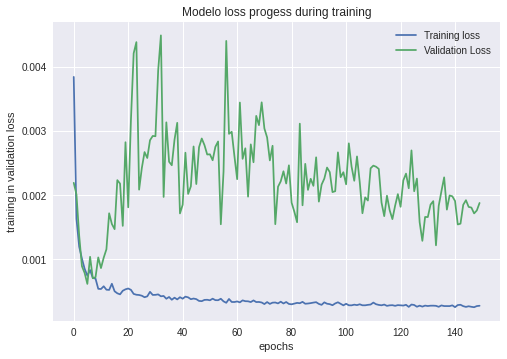

In [62]:
plt.plot(epochs_hist.history['loss'])
plt.plot(epochs_hist.history['val_loss'])
plt.title('Modelo loss progess during training')
plt.xlabel('epochs')
plt.ylabel('training in validation loss')
plt.legend(['Training loss', 'Validation Loss'])

In [75]:
scaled_numerical = numerical_scaler.fit_transform(X_test[numerical])
hot_encoded = binary_ohe.fit_transform(X_test[binary])
condition = quality_1.fit_transform(X_test['condition'].values.reshape(-1, 1))
grade = quality_2.fit_transform(X_test['grade'].values.reshape(-1, 1))

/home/dsntos/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [76]:
X_test_final = pd.DataFrame(scaled_numerical, columns=numerical)

condition = pd.DataFrame(condition.reshape(-1, 1))
grade = pd.DataFrame(grade.reshape(-1, 1))

cdt_grd = pd.concat([condition, grade], axis=1)
cdt_grd.columns = ['condition', 'grade']
cdt_grd = quality_scaler.transform(cdt_grd)
cdt_grd = pd.DataFrame(cdt_grd, columns=['condition', 'grade'])

In [77]:
X_test_final = pd.concat([X_test_final, cdt_grd], axis=1)

In [78]:

scaled_hot = hot_scaler.transform(pd.DataFrame(hot_encoded.toarray()))
scaled_hot = pd.DataFrame(scaled_hot)
X_test_final = pd.concat([X_test_final, scaled_hot], axis=1)

In [79]:
y_test_encoded = y_scaler.transform(y_test.values.reshape(-1, 1))

In [80]:
y_pred_encoded = model.predict(X_test_final)

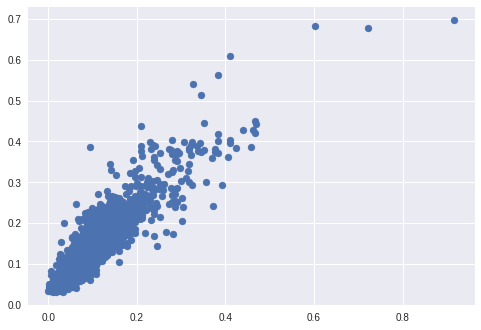

In [81]:
plt.scatter(y_test_encoded, y_pred_encoded)

In [82]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [83]:
k = X_test_final.shape[1]
n = len(X_test_final)

In [84]:
y_pred = y_scaler.inverse_transform(y_pred_encoded)

In [85]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

In [86]:
print(f'MAE {mae}')
print(f'MSE {mse}')
print(f'RMSE {rmse}')
print(f'R2 {r2}')
print(f'R2 Ajustado {adj_r2}')

MAE 258797.5568200595
MSE 90712934396.62247
RMSE 301185.8801415207
R2 0.32276811915660697
R2 Ajustado 0.3148880638358399


In [74]:
print(f'MAE {mae}')
print(f'MSE {mse}')
print(f'RMSE {rmse}')
print(f'R2 {r2}')
print(f'R2 Ajustado {adj_r2}')

MAE 288079.85385822866
MSE 103172544195.3662
RMSE 321204.83214822004
R2 0.22974891484242976
R2 Ajustado 0.22078651756963208


In [56]:
y_test

9053      350000.0
11461     275000.0
3508      695000.0
21600    1537000.0
9728      215000.0
           ...    
15061     725000.0
13570     394000.0
15967     615000.0
17592     350000.0
17356     905000.0
Name: price, Length: 7565, dtype: float64

In [57]:
y_pred

array([[712522.7 ],
       [686227.3 ],
       [894167.3 ],
       ...,
       [953828.2 ],
       [677186.06],
       [995349.3 ]], dtype=float32)

In [35]:
350000.0  - 375594.03

-25594.030000000028